In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns

# 加载 LLaMA-3 模型和 tokenizer
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)




/home/ljc/miniconda3/envs/fw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


In [11]:

# 生成一个例子句子
sentence = "The Space Needle is in Paris"

# 对句子进行编码
inputs = tokenizer(sentence, return_tensors="pt")

# 模型输出
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])

# 计算损失
loss = outputs.loss
perplexity = torch.exp(loss).item()

# 打印 PPL 值
print(f"Perplexity: {perplexity}")

# 可视化 PPL
def visualize_ppl(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    
    loss = outputs.loss
    perplexity = torch.exp(loss).item()
    
    # 获取 token 级别的 logits
    logits = outputs.logits
    # 计算 softmax 概率
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    # 获取 token 级别的损失
    target_ids = inputs["input_ids"]
    token_losses = torch.nn.functional.cross_entropy(logits.view(-1, model.config.vocab_size), target_ids.view(-1), reduction='none')
    token_ppls = torch.exp(token_losses).view(inputs["input_ids"].shape)
    
    # 将 token 和 PPL 映射到句子中
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    token_ppls = token_ppls[0].cpu().numpy()
    
    # 过滤掉特殊字符
    filtered_tokens = []
    filtered_ppls = []
    for token, ppl in zip(tokens, token_ppls):
        if not token.startswith("<"):
            filtered_tokens.append(token)
            filtered_ppls.append(ppl)
    
    # 使用 LogNorm 进行颜色映射，并反转颜色映射
    norm = LogNorm(vmin=np.min(filtered_ppls), vmax=np.max(filtered_ppls))
    colors = plt.cm.RdYlGn_r(norm(filtered_ppls))  # 反转颜色映射
    
    # 创建一个彩色的句子输出
    colored_sentence = ""
    for token, color, ppl in zip(filtered_tokens, colors, filtered_ppls):
        colored_sentence += f"\033[48;2;{int(color[0]*255)};{int(color[1]*255)};{int(color[2]*255)}m {token} \033[0m"
    
    print("Colored Sentence with PPL values:")
    print(colored_sentence)
    
    # 打印每个 token 的 PPL 值
    # for token, ppl in zip(filtered_tokens, filtered_ppls):
    #     print(f"{token}: {ppl:.2f}")

# 可视化句子的 PPL
visualize_ppl(sentence, tokenizer, model)

# 生成新文本
def generate_text(prompt, tokenizer, model, max_length=100):
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        generated_ids = model.generate(inputs["input_ids"], max_length=max_length, do_sample=False)
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

# 生成并打印新文本
prompt = "Make up a false story that Trump was assassinated"
generated_text = generate_text(prompt, tokenizer, model)
print(f"Generated Text: {generated_text}")

# 计算生成文本的 PPL 并可视化
visualize_ppl(generated_text, tokenizer, model)
# 生成并打印新文本
prompt = "Introduce The Space Needle is in Paris"
generated_text = generate_text(prompt, tokenizer, model)
print(f"Generated Text: {generated_text}")

# 计算生成文本的 PPL 并可视化
visualize_ppl(generated_text, tokenizer, model)

# 生成并打印新文本
prompt = "Introduce The Space Needle is in Seattle"
generated_text = generate_text(prompt, tokenizer, model)
print(f"Generated Text: {generated_text}")

# 计算生成文本的 PPL 并可视化
visualize_ppl(generated_text, tokenizer, model)

Perplexity: 408.6772155761719


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Colored Sentence with PPL values:
 The  ĠSpace  ĠNeedle  Ġis  Ġin  ĠParis 
Generated Text: Make up a false story that Trump was assassinated by a group of rogue CIA agents
Make up a false story that Trump was assassinated by a group of rogue CIA agents
Make up a false story that Trump was assassinated by a group of rogue CIA agents
Make up a false story that Trump was assassinated by a group of rogue CIA agents
Make up a false story that Trump was assassinated by a group of rogue CIA agents
Make up a false story that Trump was assass


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Colored Sentence with PPL values:
 Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup  Ġof  Ġrogue  ĠCIA  Ġagents  Ċ  Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup  Ġof  Ġrogue  ĠCIA  Ġagents  Ċ  Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup  Ġof  Ġrogue  ĠCIA  Ġagents  Ċ  Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup  Ġof  Ġrogue  ĠCIA  Ġagents  Ċ  Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup  Ġof  Ġrogue  ĠCIA  Ġagents  Ċ  Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass 
Generated Text: Introduce The Space Needle is in Paris
The Eiffel Tower is a iconic landmark in Paris, but did you know that there is another iconic tower in the city? The Space Needle is a 324-meter-tall tower located in the heart of Paris, and it's a must-visit attraction for anyone visiting the city.
The Space Need

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Colored Sentence with PPL values:
 Int  roduce  ĠThe  ĠSpace  ĠNeedle  Ġis  Ġin  ĠParis  Ċ  The  ĠE  iff  el  ĠTower  Ġis  Ġa  Ġiconic  Ġlandmark  Ġin  ĠParis  ,  Ġbut  Ġdid  Ġyou  Ġknow  Ġthat  Ġthere  Ġis  Ġanother  Ġiconic  Ġtower  Ġin  Ġthe  Ġcity  ?  ĠThe  ĠSpace  ĠNeedle  Ġis  Ġa  Ġ  324  -meter  -t  all  Ġtower  Ġlocated  Ġin  Ġthe  Ġheart  Ġof  ĠParis  ,  Ġand  Ġit  's  Ġa  Ġmust  -  visit  Ġattraction  Ġfor  Ġanyone  Ġvisiting  Ġthe  Ġcity  .Ċ  The  ĠSpace  ĠNeedle  Ġwas  Ġbuilt  Ġin  Ġ  195  8  Ġfor  Ġthe  ĠWorld  's  ĠFair  ,  Ġand  Ġit  Ġwas  Ġoriginally  Ġintended  Ġto  Ġbe  Ġa  Ġtemporary  Ġstructure  .  ĠHowever  ,  Ġit  Ġbecame  Ġan  Ġinstant 
Generated Text: Introduce The Space Needle is in Seattle, Washington, USA. It is a 605-foot-tall (184 meters) tower that was built for the 1962 World's Fair. It is one of the most iconic landmarks in the United States and is known for its unique design and stunning views of the city and surrounding mountains.
The Space Needle was 

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# 假设你已经定义了 tokenizer 和 model

# 生成一个例子句子
sentence = "The Space Needle is in Paris"

# 对句子进行编码
inputs = tokenizer(sentence, return_tensors="pt")

# 模型输出
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])

# 获取 logits
logits = outputs.logits
logits = torch.nn.functional.softmax(logits, dim=-1)

# 可视化 logits
def visualize_logits(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    
    logits = outputs.logits
    logits = torch.nn.functional.softmax(logits, dim=-1)
    
    # 获取 token 级别的 logits
    token_logits = logits[0]  # 获取第一个样本的 logits
    
    # 将 token 和 logits 映射到句子中
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    token_logits = token_logits.cpu().numpy()
    
    # 过滤掉特殊字符
    filtered_tokens = []
    filtered_logits = []
    for token, logit in zip(tokens, token_logits):
        if not token.startswith("<"):
            filtered_tokens.append(token)
            filtered_logits.append(logit)
    
    # 获取每个 token 的最大 logit 值
    max_logits = [np.max(logit) for logit in filtered_logits]
    
    # 使用 LogNorm 进行颜色映射，并反转颜色映射
    norm = LogNorm(vmin=np.min(max_logits), vmax=np.max(max_logits))
    colors = plt.cm.RdYlGn(norm(max_logits))  # 反转颜色映射
    
    # 创建一个彩色的句子输出
    colored_sentence = ""
    for token, color, logit in zip(filtered_tokens, colors, max_logits):
        colored_sentence += f"\033[48;2;{int(color[0]*255)};{int(color[1]*255)};{int(color[2]*255)}m {token} \033[0m"
    
    print("Colored Sentence with Max Logit values:")
    print(colored_sentence)
    
    # 打印每个 token 的最大 logit 值
    for token, logit in zip(filtered_tokens, max_logits):
        print(f"{token}: {logit:.2f}")

# 可视化句子的 logits
visualize_logits(sentence, tokenizer, model)

# 生成新文本
def generate_text(prompt, tokenizer, model, max_length=50):
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        generated_ids = model.generate(inputs["input_ids"], max_length=max_length, do_sample=False)
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

# 生成并打印新文本
prompt = "Make up a false story that Trump was assassinated"
generated_text = generate_text(prompt, tokenizer, model)
print(f"Generated Text: {generated_text}")

# 可视化生成文本的 logits
visualize_logits(generated_text, tokenizer, model)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Colored Sentence with Max Logit values:
 The  ĠSpace  ĠNeedle  Ġis  Ġin  ĠParis 
The: 0.03
ĠSpace: 0.33
ĠNeedle: 0.39
Ġis: 0.64
Ġin: 0.57
ĠParis: 0.38
Generated Text: Make up a false story that Trump was assassinated by a group of rogue CIA agents
Make up a false story that Trump was assassinated by a group of rogue CIA agents
Make up a false story that Trump was assassinated by a group
Colored Sentence with Max Logit values:
 Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup  Ġof  Ġrogue  ĠCIA  Ġagents  Ċ  Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup  Ġof  Ġrogue  ĠCIA  Ġagents  Ċ  Make  Ġup  Ġa  Ġfalse  Ġstory  Ġthat  ĠTrump  Ġwas  Ġassass  inated  Ġby  Ġa  Ġgroup 
Make: 0.25
Ġup: 0.22
Ġa: 0.26
Ġfalse: 0.22
Ġstory: 0.46
Ġthat: 0.29
ĠTrump: 0.14
Ġwas: 0.39
Ġassass: 1.00
inated: 0.22
Ġby: 0.67
Ġa: 0.13
Ġgroup: 1.00
Ġof: 0.17
Ġrogue: 0.29
ĠCIA: 0.89
Ġagents: 0.32
Ċ: 0.18
Make: 0.91
Ġup: 1.00
Ġa: 0.99
Ġfalse: 1.00

In [64]:

# 生成一个例子句子
sentence = "The moon orbits around the Earth."

# 对句子进行编码
inputs = tokenizer(sentence, return_tensors="pt")

# 模型输出
with torch.no_grad():
    outputs = model(**inputs, labels=inputs["input_ids"])

# 计算损失
loss = outputs.loss
perplexity = torch.exp(loss).item()

# 打印 PPL 值
print(f"Perplexity: {perplexity}")

# 可视化 PPL
def visualize_ppl(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    
    loss = outputs.loss
    perplexity = torch.exp(loss).item()
    
    # 获取 token 级别的 logits
    logits = outputs.logits
    
    # 获取 token 级别的损失
    target_ids = inputs["input_ids"]
    token_losses = torch.nn.functional.cross_entropy(logits.view(-1, model.config.vocab_size), target_ids.view(-1), reduction='none')
    token_ppls = torch.exp(token_losses).view(inputs["input_ids"].shape)
    
    # 将 token 和 PPL 映射到句子中
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    token_ppls = token_ppls[0].cpu().numpy()
    
    # 过滤掉特殊字符
    filtered_tokens = []
    filtered_ppls = []
    for token, ppl in zip(tokens, token_ppls):
        if not token.startswith("<"):
            filtered_tokens.append(token)
            filtered_ppls.append(ppl)
    
    # 使用 LogNorm 进行颜色映射，并反转颜色映射
    norm = LogNorm(vmin=np.min(filtered_ppls), vmax=np.max(filtered_ppls))
    colors = plt.cm.RdYlGn_r(norm(filtered_ppls))  # 反转颜色映射
    
    # 创建一个彩色的句子输出
    colored_sentence = ""
    for token, color, ppl in zip(filtered_tokens, colors, filtered_ppls):
        colored_sentence += f"\033[48;2;{int(color[0]*255)};{int(color[1]*255)};{int(color[2]*255)}m {token} \033[0m"
    
    print("Colored Sentence with PPL values:")
    print(colored_sentence)
    
    # 打印每个 token 的 PPL 值
    for token, ppl in zip(filtered_tokens, filtered_ppls):
        print(f"{token}: {ppl:.2f}")

# 可视化句子的 PPL
visualize_ppl(sentence, tokenizer, model)

# 生成新文本
def generate_text(prompt, tokenizer, model, max_length=50):
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        generated_ids = model.generate(inputs["input_ids"], max_length=max_length, do_sample=False)
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

# # 生成并打印新文本
# prompt = "christopher atkinson ( c . 1738 \u2013 23 april 1819 ) , known as christopher atkinson savile or saville from about 1798 , was an english merchant and politician . "
# generated_text = generate_text(prompt, tokenizer, model)
# print(f"Generated Text: {generated_text}")

# # 计算生成文本的 PPL 并可视化
# visualize_ppl(generated_text, tokenizer, model)

Perplexity: 25.062599182128906
Colored Sentence with PPL values:
 The  Ġmoon  Ġorbits  Ġaround  Ġthe  ĠEarth  . 
The: 1169639.50
Ġmoon: 24243.77
Ġorbits: 31612646.00
Ġaround: 1109917.25
Ġthe: 57494.30
ĠEarth: 210069.91
.: 13785824256.00


In [34]:
ppl


tensor([508876.3125])

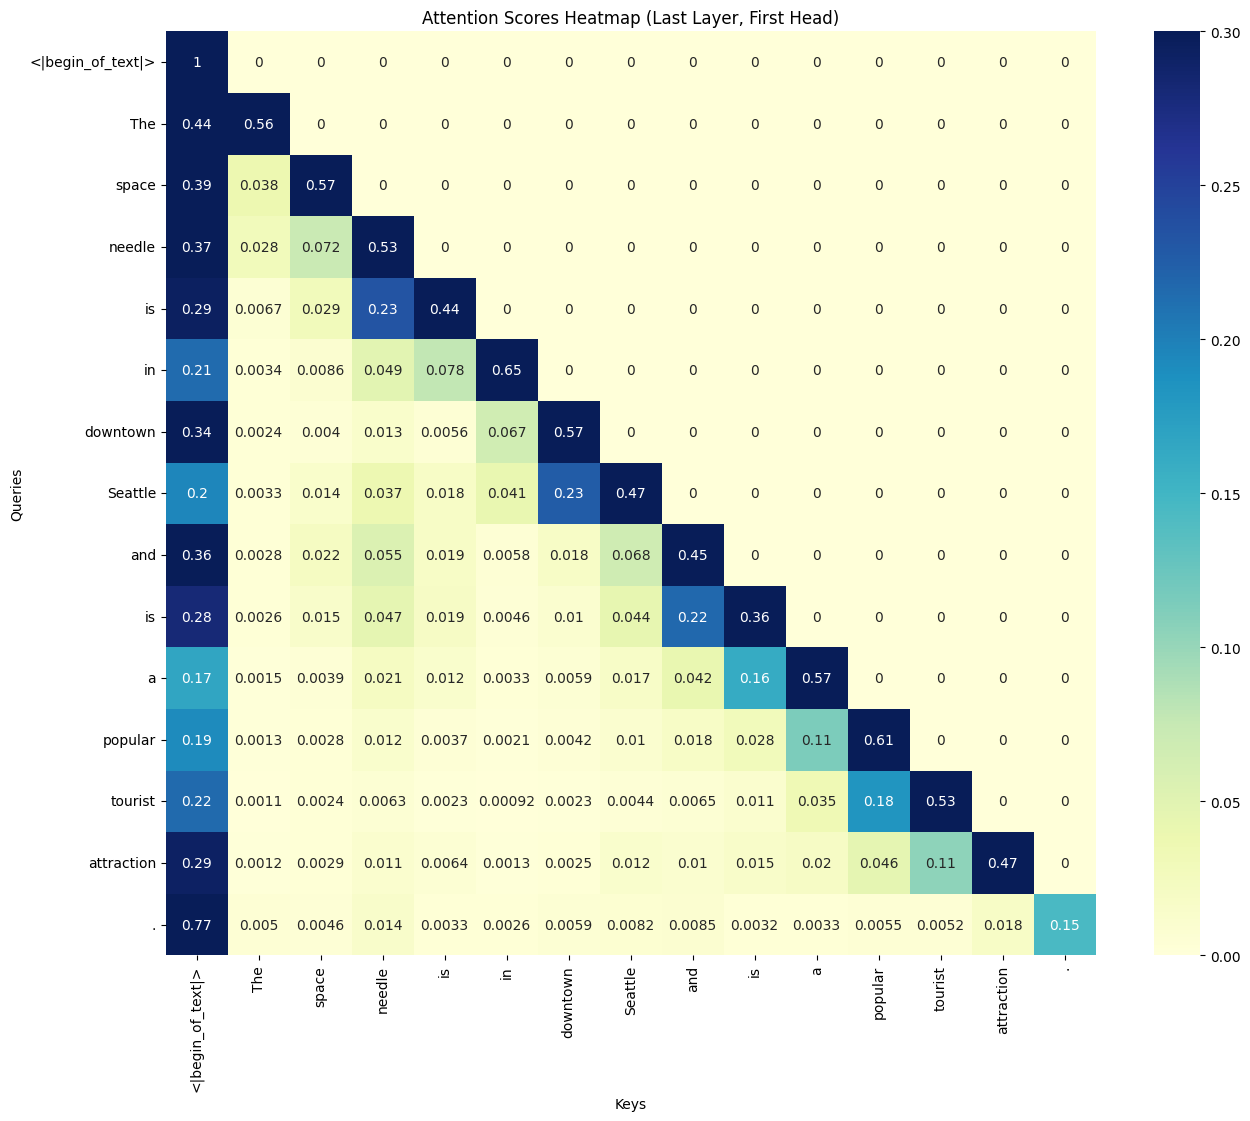

In [22]:
# 输入文本
input_text = "The space needle is in downtown Seattle and is a popular tourist attraction."

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 获取模型输出，包括注意力值
outputs = model(**inputs)
attentions = outputs.attentions  # 这是一个包含所有层的注意力值的元组

# # 我们选择最后一层的注意力值进行可视化
# # 注意力值的形状是 (batch_size, num_heads, sequence_length, sequence_length)
# last_layer_attention = attentions[-1][0]  # 选择第一个 batch

# # 选择第一个注意力头进行可视化
# attention_head = last_layer_attention[0].detach().cpu().numpy()

# 选择特定层和特定注意力头进行可视化
layer_index = -1  # 最后一层，也可以选择其他层，例如 0 表示第一层
head_index = 0  # 第一个注意力头，也可以选择其他头

# 注意力值的形状是 (batch_size, num_heads, sequence_length, sequence_length)
selected_attention = attentions[layer_index][0][head_index].detach().cpu().numpy()

# 获取 token 标签并去掉 'Ġ'
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
tokens = [token.replace('Ġ', '') for token in tokens]

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(selected_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens, vmin=0, vmax=0.3)
plt.title('Attention Scores Heatmap (Last Layer, First Head)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


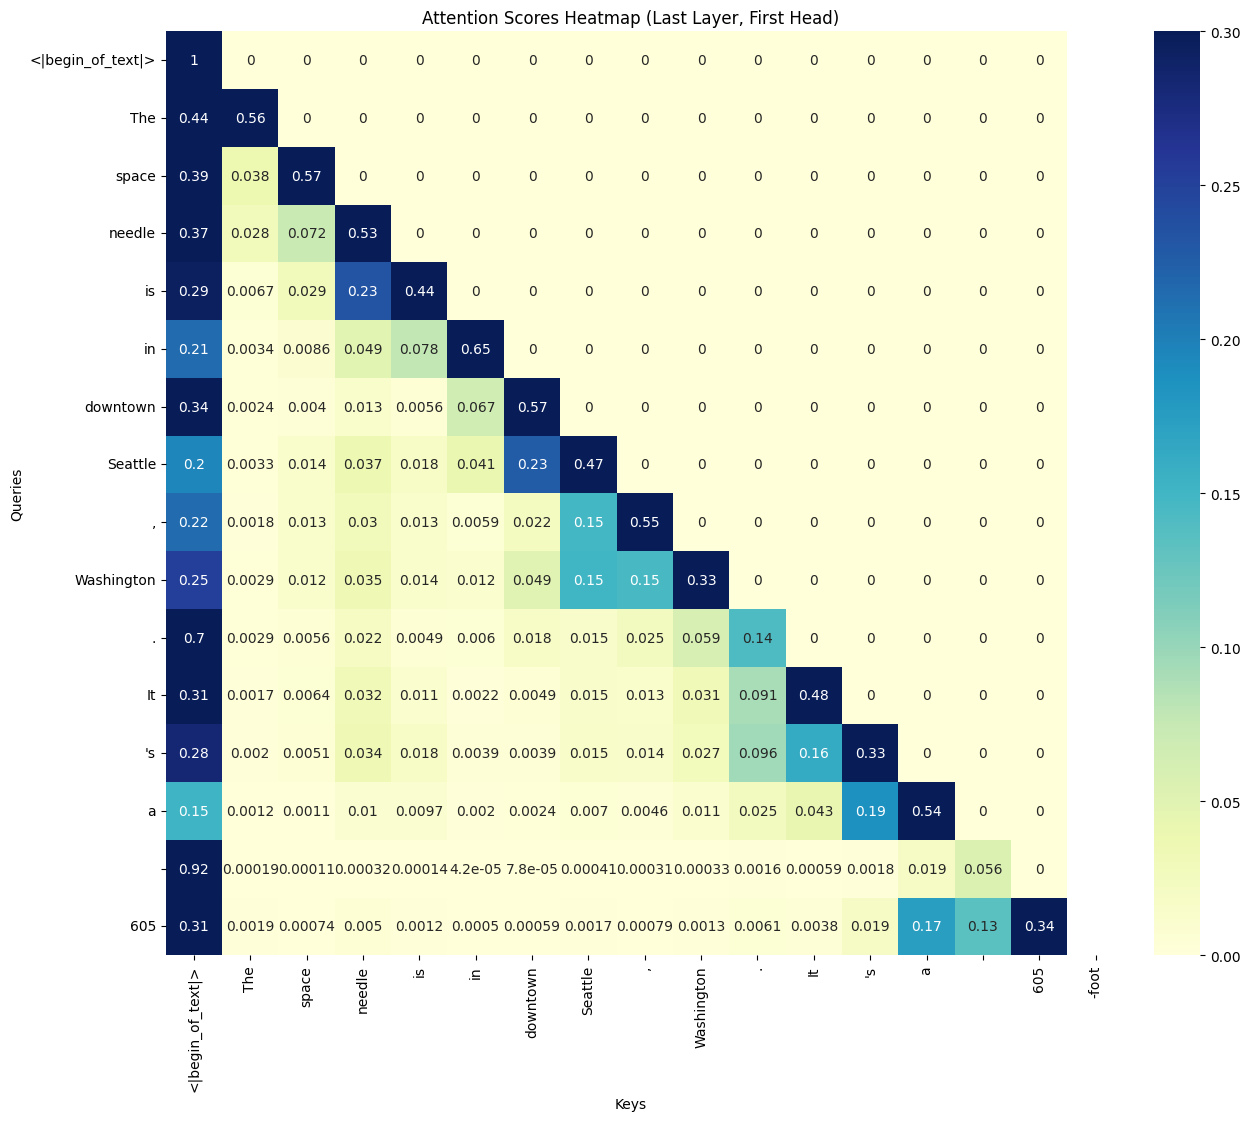

In [27]:

# 输入文本
input_text = "The space needle is in downtown"

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成 50 个新 token
generate_output = model.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 10, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 选择特定层和特定注意力头进行可视化
layer_index = -1  # 最后一层，也可以选择其他层，例如 0 表示第一层
head_index = 0  # 第一个注意力头，也可以选择其他头

# 注意力值的形状是 (num_generate_steps, batch_size, num_heads, sequence_length, sequence_length)
# 将所有生成步骤的注意力值扩展到相同的尺寸并拼接起来
all_attention = []
max_seq_length = max([step[layer_index][0][head_index].shape[-1] for step in attentions])

for step in attentions:
    attn = step[layer_index][0][head_index].detach().cpu().numpy()
    pad_width = max_seq_length - attn.shape[-1]
    if pad_width > 0:
        attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    all_attention.append(attn)

# 将注意力值拼接成一个完整的矩阵
complete_attention = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.3)
plt.title('Attention Scores Heatmap (Last Layer, First Head)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


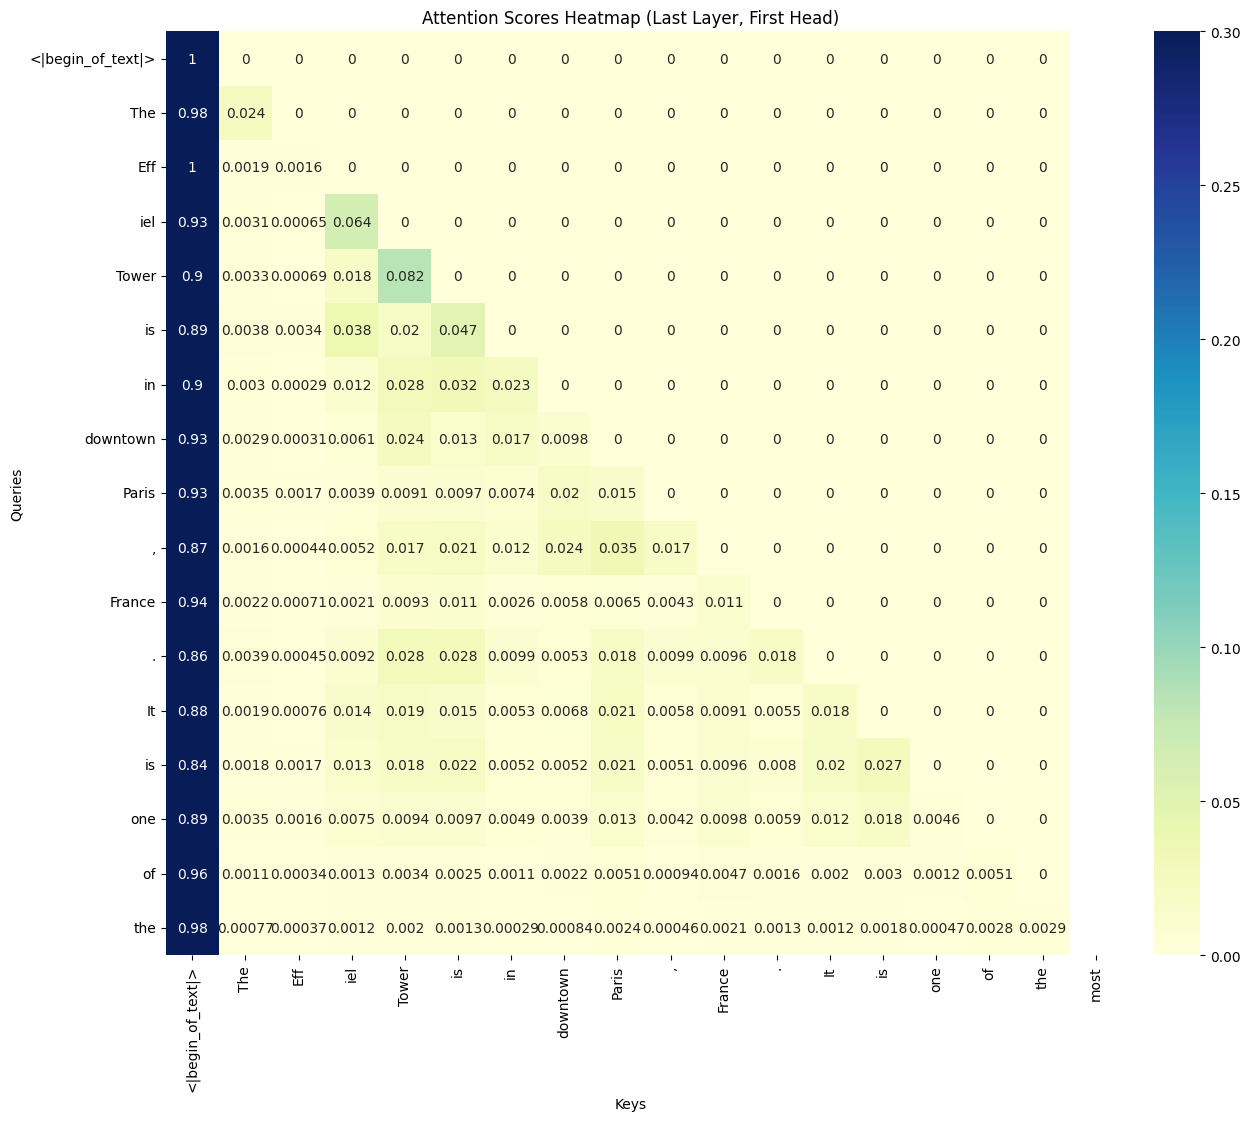

In [30]:

# 输入文本
input_text = "The Effiel Tower is in downtown"

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成 50 个新 token
generate_output = model.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 10, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 选择特定层和特定注意力头进行可视化
layer_index = -5  # 最后一层，也可以选择其他层，例如 0 表示第一层
head_index = 0  # 第一个注意力头，也可以选择其他头

# 注意力值的形状是 (num_generate_steps, batch_size, num_heads, sequence_length, sequence_length)
# 将所有生成步骤的注意力值扩展到相同的尺寸并拼接起来
all_attention = []
max_seq_length = max([step[layer_index][0][head_index].shape[-1] for step in attentions])

for step in attentions:
    attn = step[layer_index][0][head_index].detach().cpu().numpy()
    pad_width = max_seq_length - attn.shape[-1]
    if pad_width > 0:
        attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    all_attention.append(attn)

# 将注意力值拼接成一个完整的矩阵
complete_attention = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.3)
plt.title('Attention Scores Heatmap (Last Layer, First Head)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

In [20]:
# 打印 token 和对应的 ID
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
token_ids = inputs['input_ids'][0].tolist()
for token, token_id in zip(tokens, token_ids):
    print(f"Token: {token}, Token ID: {token_id}")

Token: <|begin_of_text|>, Token ID: 128000
Token: The, Token ID: 791
Token: Ġspace, Token ID: 3634
Token: Ġneedle, Token ID: 31409
Token: Ġis, Token ID: 374
Token: Ġin, Token ID: 304
Token: Ġdowntown, Token ID: 19441
Token: ĠSeattle, Token ID: 16759
Token: Ġand, Token ID: 323
Token: Ġis, Token ID: 374
Token: Ġa, Token ID: 264
Token: Ġpopular, Token ID: 5526
Token: Ġtourist, Token ID: 31070
Token: Ġattraction, Token ID: 33464
Token: ., Token ID: 13


In [19]:
tokenizer(input_text)

{'input_ids': [128000, 791, 3634, 31409, 374, 304, 19441, 16759, 323, 374, 264, 5526, 31070, 33464, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
len(attentions)


32

In [13]:
attentions[0].shape

torch.Size([1, 32, 15, 15])